In [7]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
import pandas as pd
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim

#library functions
import dataloading
import data_vis
import model_functions

In [8]:
torch.manual_seed(1234)

In [9]:
labels_csv = "camera_data/coronado_hills_binary_10-24-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [10]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

train_dataset, val_dataset, test_dataset = dataloading.get_datasets(train, val, test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=True)

In [11]:
# Importing the model and setting the device. Using a ViT model since transformer architecture is generally pretty powerful when it comes to extracting features from data.
model_name = "google/vit-base-patch16-224"
vit = ViTModel.from_pretrained(model_name, torch_dtype=torch.float32)
device = "cuda" #Change to cpu if you aren't using a GPU

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
#Creating a new model class that is essentially just the ViT model minus the classification head. This will get us our features.
class ViTEmbeddingNet(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model

    def forward(self, pixel_values: torch.FloatTensor,labels: torch.LongTensor = None):
        outputs = self.vit(pixel_values)
        # Use [CLS] token (first token in the sequence) as embedding
        return outputs.last_hidden_state[:, 0]

In [13]:
#Instatiating encoder and loading it to chosen device
encoder = ViTEmbeddingNet(vit)

encoder.to(device) 

ViTEmbeddingNet(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_f

In [ ]:
#Defining optimizer, loss function, and what kind of mining to use for triplets
num_epochs = 2
loss_func = model_functions.triplet_loss()
optimizer = optim.Adam(encoder.parameters(), lr=2e-5) 

In [15]:
#This is where we would train the model (it's commented out because it takes about ~1.5 hours to run each time), just loading the weights here instead
#losses = model_functions.train_model(encoder, num_epochs=num_epochs, loss_func=loss_func, optimizer=optimizer)

In [16]:
encoder.load_state_dict(torch.load('weights/model_weights_camera_10-27-25.pth', weights_only=True))
encoder.eval()

ViTEmbeddingNet(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_f

In [17]:
raw_embeddings, raw_labels = model_functions.get_batch_embeddings(encoder, val_dataloader)

In [19]:
embeddings, labels = model_functions.reduce_pca(raw_embeddings, raw_labels)

Accuracy: 0.90625


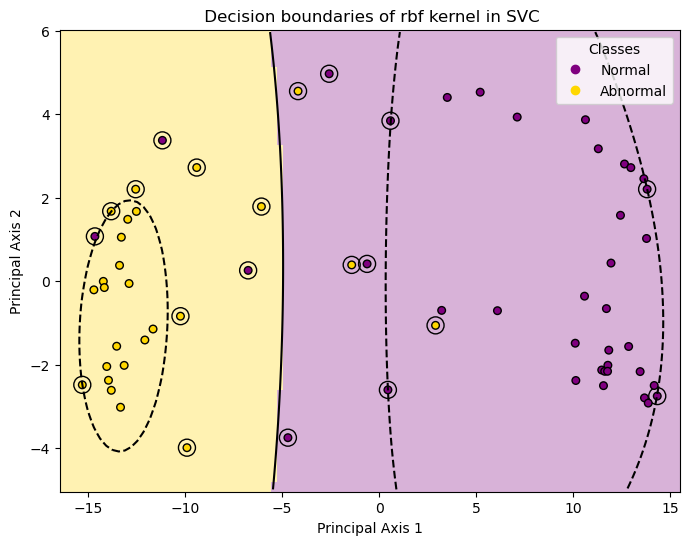

In [22]:
svm = data_vis.plot_with_decision_boundary('rbf', embeddings, labels)

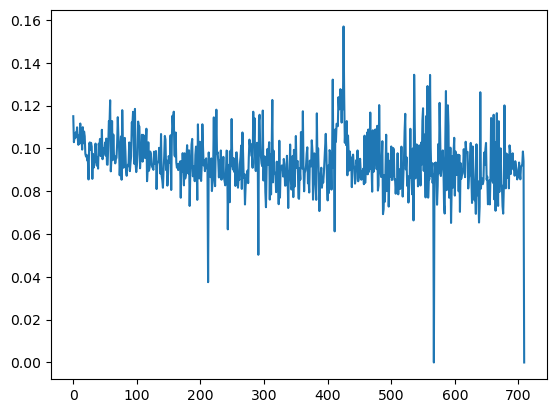

In [ ]:
import matplotlib.pyplot as plt

#plt.plot(list(range(len(losses))), losses)